# Lab 3 Schokley Ramo Theorem Code setup
Kalie Knecht
heavily inspired by https://github.com/lbl-anp/GammaRayTrackingSchool_2018/

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# general package imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit
from scipy.stats import linregress
# from spectrum import gaussian
import pandas as pd

# import tool repo
import sys

# UPDATE PATH TO PATH WHERE YOU HAVE REPO SAVED
# sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab2')
# from tools import find_activity, import_data, subtract_baseline
# from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter
# from spectrum import spectrum, gaussian
# from pulse_shape import find_rise_time

In [28]:
# set detector params

# Detector is a 1 x 1 x 1 cm3 CdZnTe crystal from Redlen Technologies 
# Cathode: full area; 
# Anode: 3 x 3 pixel array surrounded by a guard ring; 
# Pixels: 0.75 x 0.75 mm2 on 1 mm pitch 

detector_width = 10.0 # mm
detector_height = 10.0 # mm
pixel_size_mm = .125 # mm
pixel_pitch_mm = 1

cathode_contact_bias = -1000.0
anode_contact_bias = 0.0

charge_density_zero = -1.0 #TODO - change
charge_density_gradient = 0.1 #TODO - change

In [70]:
# build (uniform) 2D grids for plotting and solving (x=width, y=height (cathode to anode))
x_range = np.arange(0, detector_width+pixel_size_mm, pixel_size_mm)
y_range = np.arange(0, detector_height+pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)

# XY mesh for plotting later
X, Y = np.meshgrid(y_range, x_range)

In [69]:
np.linspace?

In [27]:
3.375/.125

27.0

3.625

0.75

In [143]:
# find anodes
left_pixel = x_range >= 3.375 +.25
left_pixel *= x_range <= 3.375 +.25+.75

middle_pixel = x_range >= 3.375 +.25+.75+.25
middle_pixel *= x_range <= 3.375 +.25+.75 +.25 +.75

right_pixel = x_range >= 3.375 +.25+.75 +.25 +.75 + .25
right_pixel *= x_range <= 3.375 +.25+.75 +.25 +.75 +.25 + .75

left_pixel_idx = np.argwhere(left_pixel).flatten()
middle_pixel_idx = np.argwhere(middle_pixel).flatten()
right_pixel_idx = np.argwhere(right_pixel).flatten()

# anode_idx = np.concatenate((left_pixel_idx,middle_pixel_idx,right_pixel_idx))

# from left
# guard ring left

# estimated gr width from info doc
gr_width_est = .75*2+.25*3+.75/2

gr_left = x_range < 3.375
gr_left *= x_range > 3.375-gr_width_est
gr_right = x_range > 3.375 +.25+.75 +.25 +.75 +.25 + .75 + .25
gr_right *= x_range < 3.375 +.25+.75 +.25 +.75 +.25 + .75 + .25 + gr_width_est
gr_left_idx = np.argwhere(gr_left).flatten()
gr_right_idx = np.argwhere(gr_right).flatten()
guard_ring_idx = np.concatenate((gr_left_idx,gr_right_idx))

In [157]:
# just a 2d slice, say through the middle of the detector
# build a little map of geometry for later, designating pixels based on their nature
# 0 = CZT
# 1 = cathode face
# 2 = guard ring
# 3 = gap 
# anodes
# 4 = anode 4 (right)
# 5 = anode 5 (middle)
# 6 = anode 6 (left)

# detector all 0
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# contacts
geom_map[-1,:] = 1 # cathode
geom_map[0,guard_ring_idx] = 2 # guard ring
geom_map[0,right_pixel_idx] = 4 # pixel 4
geom_map[0,middle_pixel_idx] = 5 # pixel 5
geom_map[0,left_pixel_idx] = 6 # pixel 6

# gaps
gap_idx = np.argwhere(geom_map[0] == 0).flatten()
geom_map[0,gap_idx] = 3
# geom_map[0,anode_idx] = 2 # anodes
geom_map

array([[3, 3, 3, ..., 3, 3, 3],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [158]:
geom_map[0]

array([3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 6, 6, 6, 6, 6, 6, 6, 3, 5, 5, 5, 5, 5, 5, 5,
       3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3])

In [98]:
# # set up charge distribution through xtal
# charge = np.zeros((N_xelements, N_yelements), dtype=float)
# pixels_to_cm = 10/pixel_size_mm

# for x in range(0, N_xelements):
#     for y in range(0, N_yelements):
#         charge[x,y] = charge_density_zero + charge_density_gradient*(y/pixels_to_cm)

# #         # core
# #         if (x_range[x]<core_radius_mm and y_range[y]<core_length_mm):
# #             charge[x,y] = 0.0
# #             geom_map[x,y] = 2

# charge

array([[-1.     , -0.99875, -0.9975 , ..., -0.9025 , -0.90125, -0.9    ],
       [-1.     , -0.99875, -0.9975 , ..., -0.9025 , -0.90125, -0.9    ],
       [-1.     , -0.99875, -0.9975 , ..., -0.9025 , -0.90125, -0.9    ],
       ...,
       [-1.     , -0.99875, -0.9975 , ..., -0.9025 , -0.90125, -0.9    ],
       [-1.     , -0.99875, -0.9975 , ..., -0.9025 , -0.90125, -0.9    ],
       [-1.     , -0.99875, -0.9975 , ..., -0.9025 , -0.90125, -0.9    ]])

<IPython.core.display.Javascript object>


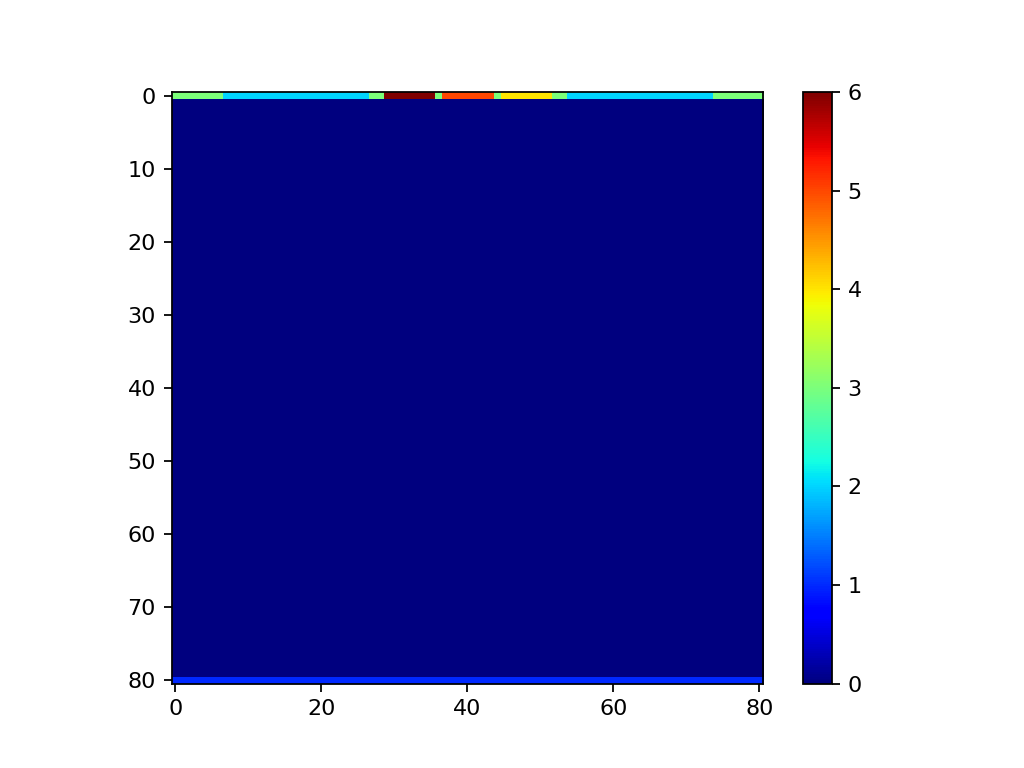

In [159]:
plt.figure()
plt.imshow(geom_map,cmap='jet')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


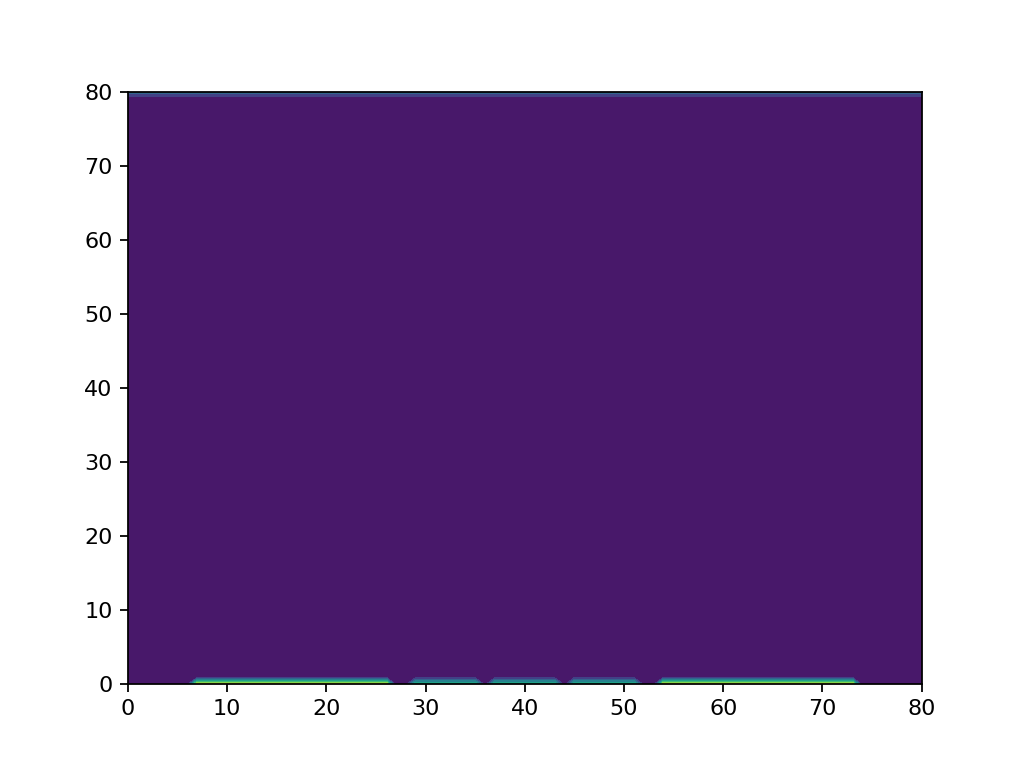

In [90]:
# view the geometry (x/y are flipped)
plt.figure()
plt.contourf(geom_map)
# ax = plt.axes()
# plt.minorticks_on()
# plt.grid("on")
# plt.xlabel('Pixel #')
# plt.ylabel('Pixel #')
plt.show()

In [109]:
# set boundary conditions and generate initial guess at solution
# 1 = cathode, 0 = core, 2 = anode
V = np.zeros((N_xelements, N_yelements), dtype=float)

# initial guess at solution
for x in range(0, N_xelements):
    for y in range(0, N_yelements):
        V[x,y] = cathode_contact_bias*x / N_xelements

# cathode
x,y = np.where(geom_map==1)
V[x,y] = cathode_contact_bias

# anode
x,y = np.where(geom_map==2)
V[x,y] = anode_contact_bias

# passivated back face (not tested)
#x,y = np.where(geom_map==3)
#V[x,y] = 0.0

In [110]:
V

array([[   -0.        ,    -0.        ,    -0.        , ...,
           -0.        ,    -0.        ,    -0.        ],
       [  -12.34567901,   -12.34567901,   -12.34567901, ...,
          -12.34567901,   -12.34567901,   -12.34567901],
       [  -24.69135802,   -24.69135802,   -24.69135802, ...,
          -24.69135802,   -24.69135802,   -24.69135802],
       ...,
       [ -962.96296296,  -962.96296296,  -962.96296296, ...,
         -962.96296296,  -962.96296296,  -962.96296296],
       [ -975.30864198,  -975.30864198,  -975.30864198, ...,
         -975.30864198,  -975.30864198,  -975.30864198],
       [-1000.        , -1000.        , -1000.        , ...,
        -1000.        , -1000.        , -1000.        ]])

<IPython.core.display.Javascript object>


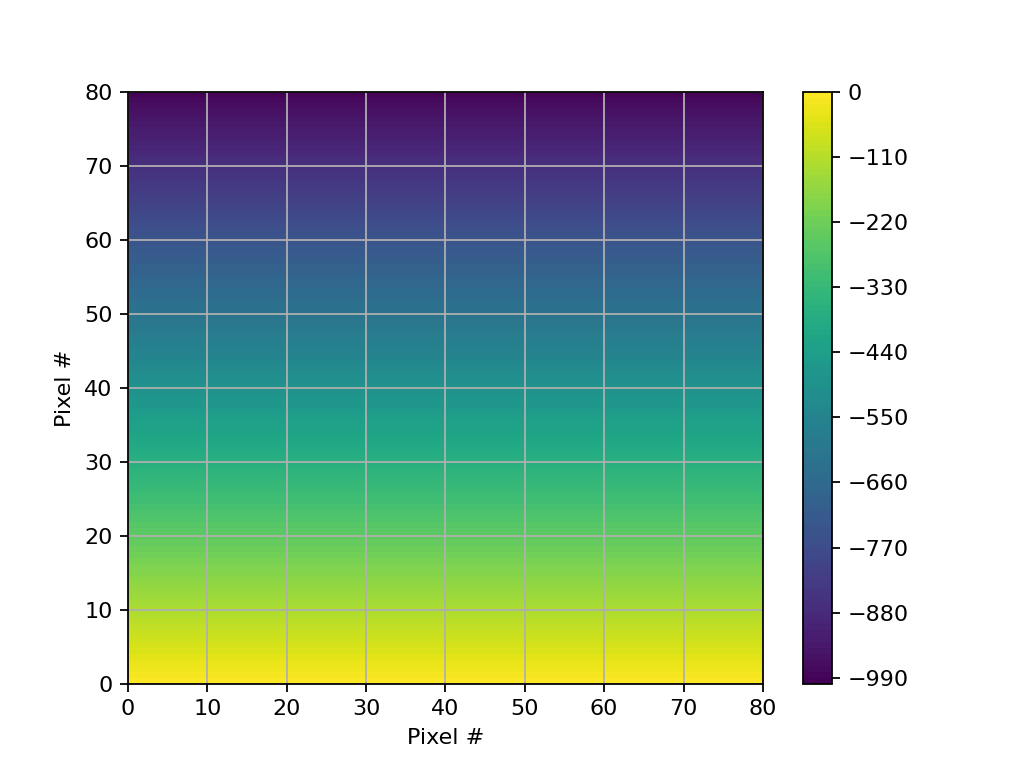

/var/folders/9q/zxs3bttx79j7gy8t3m35pzm40000gn/T/ipykernel_13785/2715891477.py:2: UserWarning: The following kwargs were not used by contour: 'interpolation'
  plt.contourf(V,100,interpolation="None")


In [111]:
plt.figure()
plt.contourf(V,100,interpolation="None")
plt.grid("on")
plt.xlabel('Pixel #')
plt.ylabel('Pixel #')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


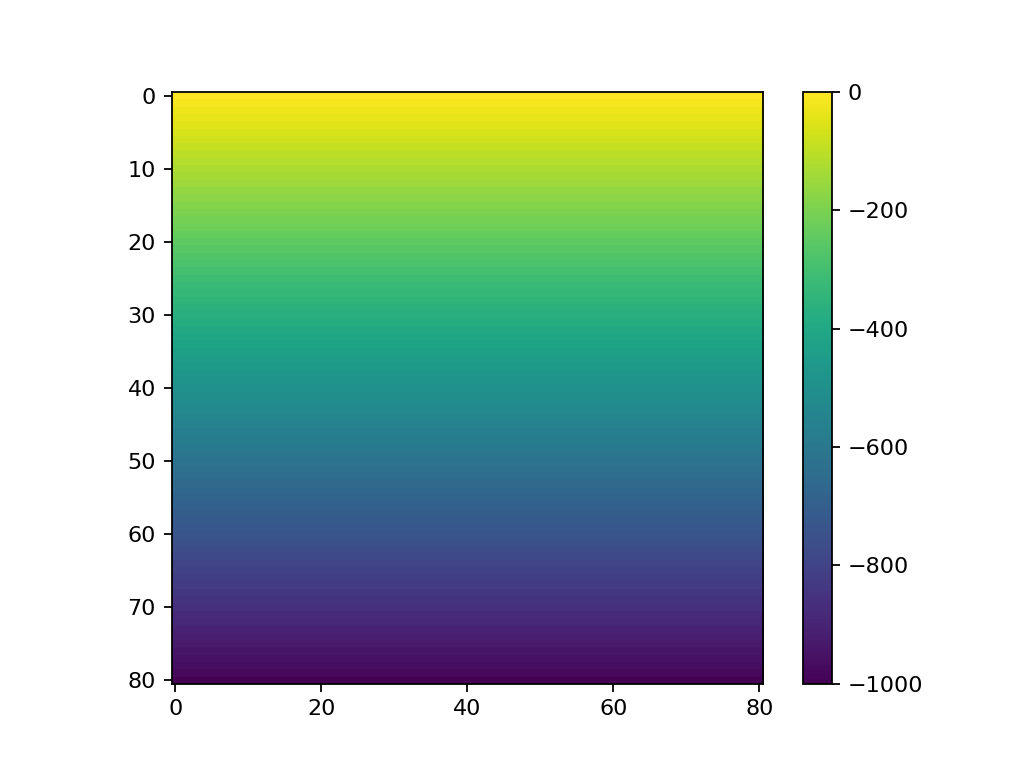

In [112]:
plt.figure()
plt.imshow(V,interpolation="None")
# plt.grid("on")
# plt.xlabel('Pixel #')
# plt.ylabel('Pixel #')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


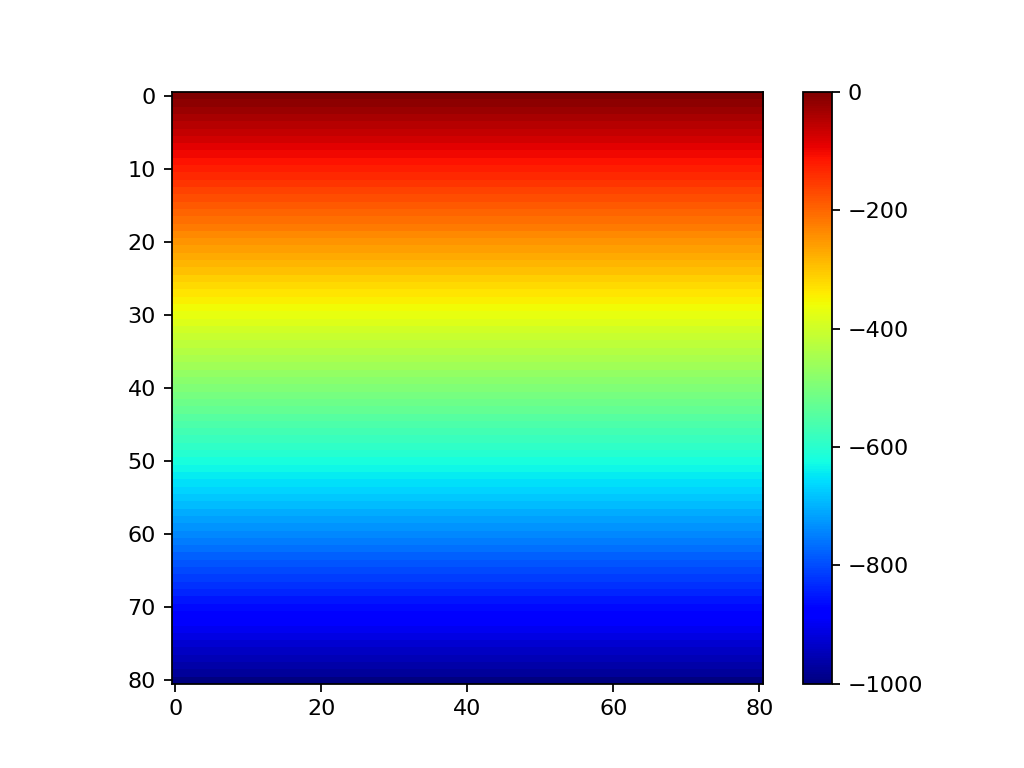

In [113]:
plt.figure()
plt.imshow(V,interpolation='None',cmap='jet')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


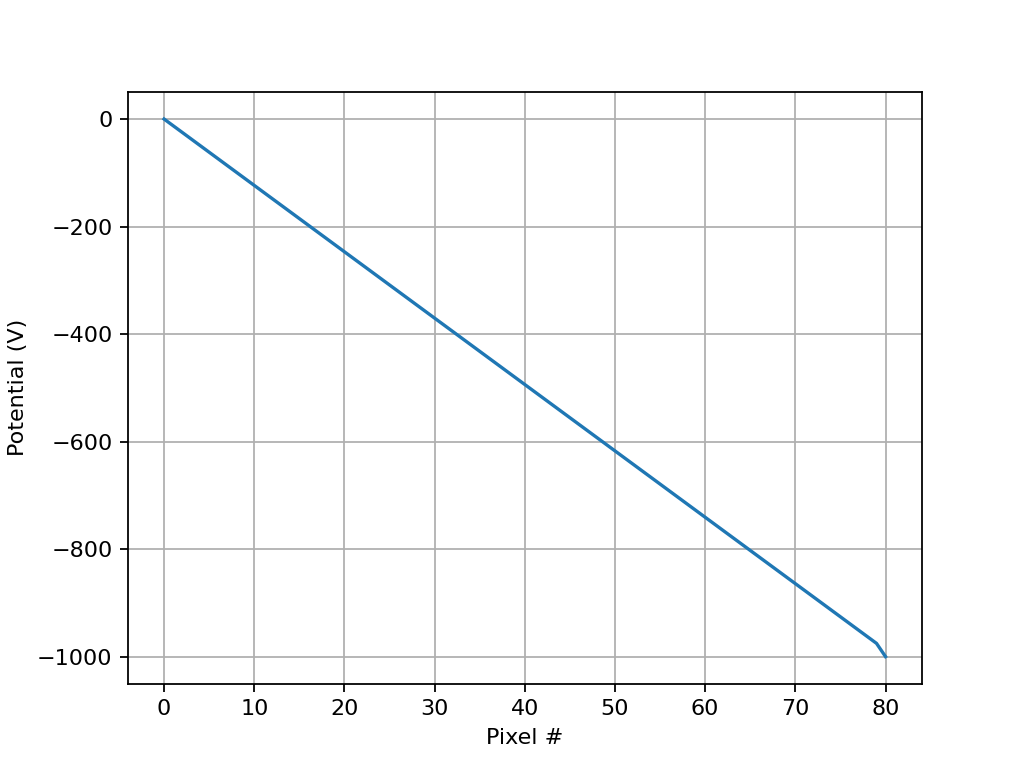

In [142]:
# plot some potential/field slices
yy = 9
xx = 9


# V along the width direction at long = xx
plt.figure()
plt.plot(V[:,yy])
plt.grid("on")
plt.xlabel("Pixel #")
plt.ylabel("Potential (V)")
plt.show()

In [115]:
#  calculate the electric field from the potential
#  - this doesn't deal with boundaries properly!
[Ex, Ey] = np.gradient(-V)
Ex = Ex * pixels_to_cm
Ey = Ey * pixels_to_cm
E = np.sqrt((Ex*Ex) + (Ey*Ey))

In [116]:
Efinal = np.flipud(E)
Efinal = np.append(Efinal, E, axis=0)

<IPython.core.display.Javascript object>


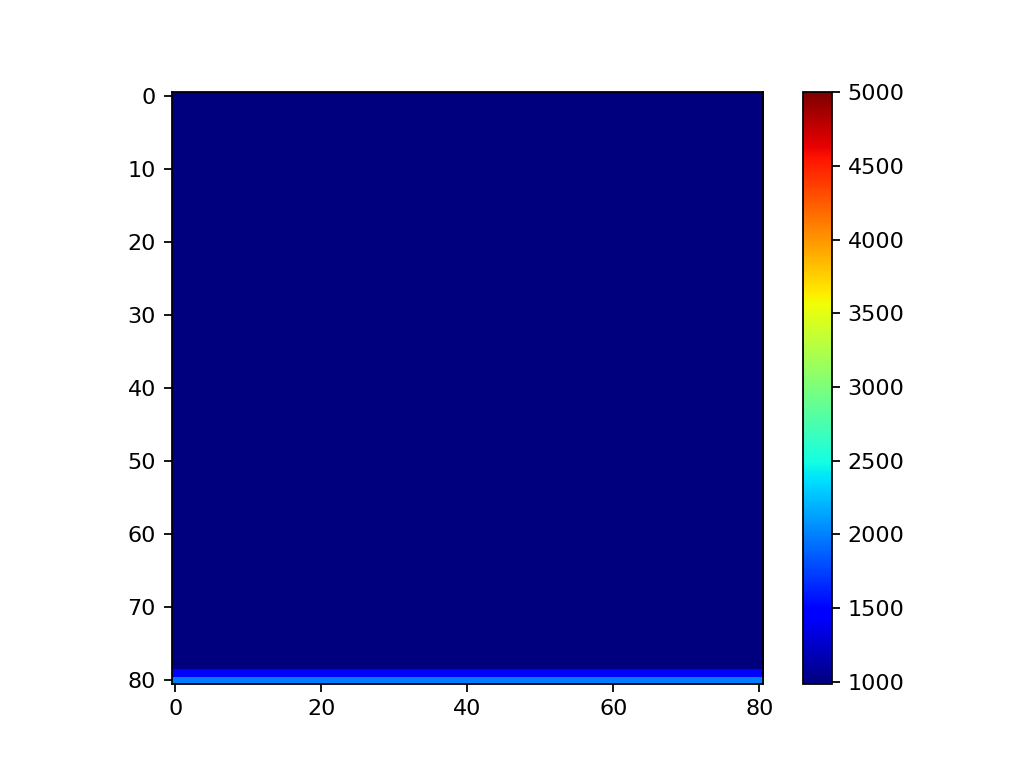

In [121]:
plt.figure()
plt.imshow(E, vmax=5000, interpolation="None", cmap="jet")
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


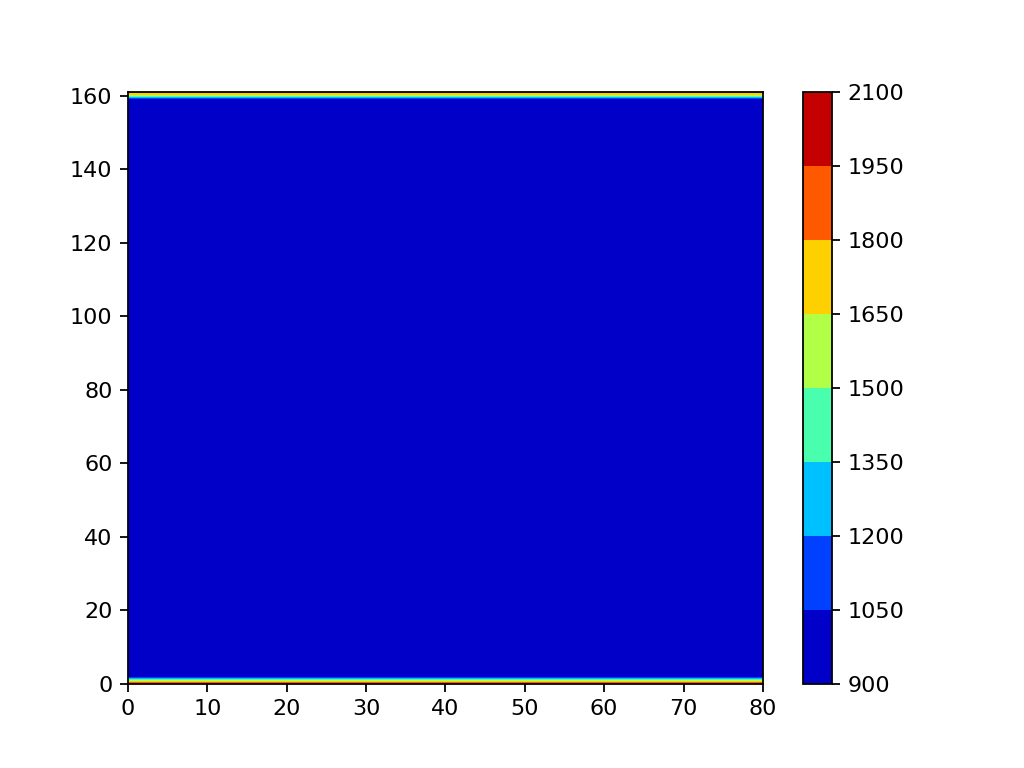

/var/folders/9q/zxs3bttx79j7gy8t3m35pzm40000gn/T/ipykernel_13785/330236695.py:2: UserWarning: The following kwargs were not used by contour: 'interpolation'
  plt.contourf(Efinal, interpolation="None", cmap="jet")


In [120]:
plt.figure()
plt.contourf(Efinal, interpolation="None", cmap="jet")
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


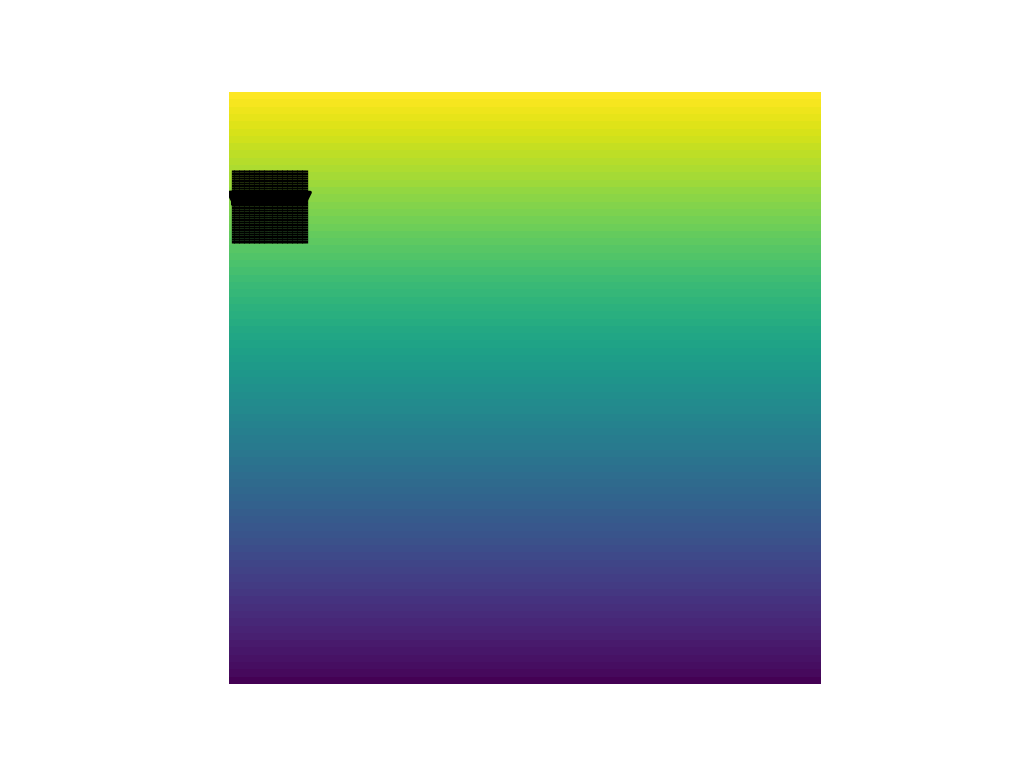

In [122]:
# plot the potential and overlay field lines
plt.figure()
lw = 3 * E/E.max()
plt.imshow(V)
plt.streamplot(X, detector_width+pixel_size_mm+Y, Ey, Ex, color='k', linewidth=lw)
plt.axis("off")
plt.show()

<IPython.core.display.Javascript object>


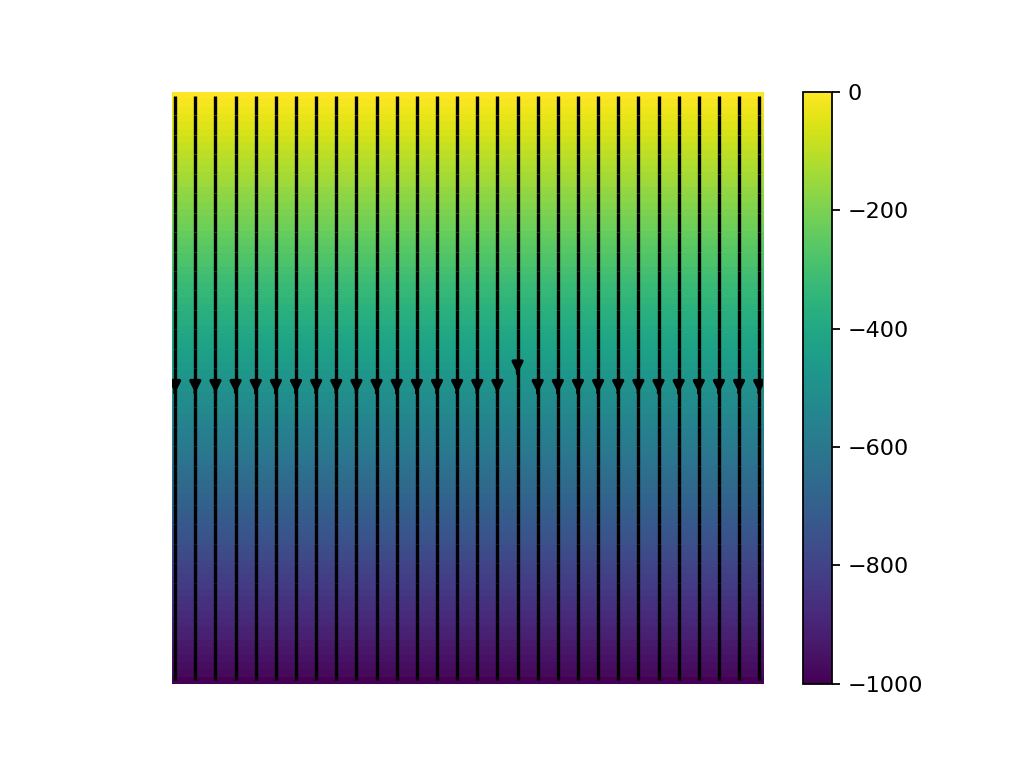

In [141]:
# plot the potential and overlay field lines
plt.figure()
lw = 3 * E/E.max()
pc = plt.imshow(V)
plt.streamplot(X*8, Y*8, Ey, Ex, color='k',linewidth=lw)
plt.colorbar(pc)
plt.axis("off")
plt.show()